## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):


### Confidence Intervals:
1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

### Chi-squared tests:
4. Take a dataset that we have used in the past in class that has **categorical** variables. Pick two of those categorical variables and run a chi-squared tests on that data
  - By hand using Numpy
  - In a single line using Scipy


In [0]:
# Imports
import scipy.stats as stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data

--2020-01-21 20:05:56--  https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18171 (18K) [application/x-httpd-php]
Saving to: ‘house-votes-84.data’

house-votes-84.data 100%[===================>]  17.75K  --.-KB/s    in 0.06s   

2020-01-21 20:05:57 (278 KB/s) - ‘house-votes-84.data’ saved [18171/18171]



In [3]:
# Create the dataframe
col_headers = ['party', 'handicapped-infants', 'water-project', 'budget', 
               'physician-fee-freeze', 'el-salvador-aid', 'religious-groups', 
               'anti-satellite-ban', 'aid-to-contras', 'mx-missile', 
               'immigration', 'synfuels', 'education', 'right-to-sue', 'crime', 
               'duty-free', 'south-africa']
df = pd.read_csv('house-votes-84.data', header=None, 
                 names=col_headers, na_values='?')
df.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,n,y,n,y,y,y,n,n,n,y,NaN,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,NaN
2,democrat,NaN,y,y,NaN,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,NaN,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,NaN,y,y,y,y


In [0]:
# replace y and n with 1 and 0
df = df.replace({'y': 1, 'n': 0})

# split dem and rep votes
rep = df[df['party'] == 'republican']
dem = df[df['party'] == 'democrat']

In [19]:
# Generate a confidence interval, using democrat votes on the budget as an example
confidence = .95
a = dem['budget'].dropna()
n = len(a)-1
mean = np.mean(a)
stderr = stats.sem(a)
stats.t.interval(confidence, n, loc=mean, scale=stderr)

(0.8499435153340716, 0.9269795615890052)

In [0]:
# Copying the manual math from the lecture to double check
def confidence_interval(data, confidence=0.95):
  """
  Calculate a confidence interval around a sample mean for given data.
  Using t-distribution and two-tailed test, default 95% confidence. 
  
  Arguments:
    data - iterable (list or numpy array) of sample observations
    confidence - level of confidence for the interval
  
  Returns:
    tuple of (mean, lower bound, upper bound)
  """
  data = np.array(data.dropna()) # drop NaN's here
  mean = np.mean(data)
  n = len(data)
  # Numpy by default calculates the "population" std_dev
  # The following line is wrong:
  # s = np.std(data) 
  # But we want the "sample" std_dev
  s = np.std(data, ddof=1) # will use n-1 in the denominator
  # And will actually calculate the sample standard deviation
  stderr = s / np.sqrt(n)
  stderr = stats.sem(data)
  margin_of_error = stderr * stats.t.ppf((1 + confidence) / 2.0, n - 1)
  return (mean, mean - margin_of_error, mean + margin_of_error)


In [14]:
confidence_interval(dem['budget'], confidence=.95)

(0.8884615384615384, 0.8499435153340716, 0.9269795615890052)

In [0]:
# Turn my solution into a function
def get_conf_int(data, confidence=.95):
  a = data.dropna()
  mh, ml = stats.t.interval(confidence, len(a)-1, loc=np.mean(a), scale=stats.sem(a))
  return np.mean(a), mh, ml

In [26]:
# Test the function
get_conf_int(dem['budget'])

(0.8884615384615384, 0.8499435153340716, 0.9269795615890052)

In [0]:
# Function to graph the confidence interval
def graph_conf_int(data, confidence=.95):
  sns.distplot(data)
  CI = get_conf_int(data)
  plt.axvline(x=CI[1], color='red')
  plt.axvline(x=CI[2], color='red')
  plt.axvline(x=CI[0], color='k');

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


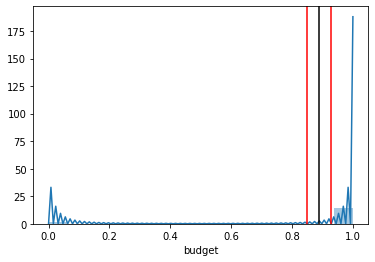

In [37]:
# Graphically represent the confidence interval
graph_conf_int(dem['budget'])

### Interpreting the confidence interval:

Assuming our data was sampled from a larger population and that it fell into a normal distribution, a confidence interval of (.888, .850, .927) would mean that this sample had 88.8% yes votes, and that based on this sample we would expect other samples taken to be between 85.0% and 92.7% yes votes, 95% of the time.

### Chi-squared tests:
4. Take a dataset that we have used in the past in class that has **categorical** variables. Pick two of those categorical variables and run a chi-squared tests on that data
  - By hand using Numpy
  - In a single line using Scipy

In [48]:
# Import a dataset with categorical data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip

--2020-01-21 21:30:42--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 579043 (565K) [application/x-httpd-php]
Saving to: ‘bank.zip’

bank.zip            100%[===================>] 565.47K  1.77MB/s    in 0.3s    

2020-01-21 21:30:43 (1.77 MB/s) - ‘bank.zip’ saved [579043/579043]



In [49]:
!unzip bank.zip

Archive:  bank.zip
  inflating: bank-full.csv           
  inflating: bank-names.txt          
  inflating: bank.csv                


In [50]:
bank_df = pd.read_csv('bank-full.csv', sep=';')
bank_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [51]:
#create the crosstab we will use
crosstab = pd.crosstab(bank_df['marital'], bank_df['education'])
crosstab

education,primary,secondary,tertiary,unknown
marital,,,,
divorced,752,2815,1471,169
married,5246,13770,7038,1160
single,853,6617,4792,528


In [0]:
# Calculate chi^2 by hand

In [57]:
# Calculate chi^2 with scipy
chi_2_stat, p_value, dof, expected = stats.chi2_contingency(crosstab)

print('chi^2 stat:', chi_2_stat)
print('p-value:', p_value)
print('degrees of freedom:', dof)
print('expected:', expected)

chi^2 stat: 1337.509872197735
p-value: 8.207753883983453e-286
degrees of freedom: 6
expected: [[  789.03711486  2672.19955321  1531.89062396   213.87270797]
 [ 4123.8440645  13966.05312866  8006.31293269  1117.78987415]
 [ 1938.11882064  6563.74731813  3762.79644334   525.33741789]]


In [60]:
chi_2_stat, p_value, dof, expected = stats.chi2_contingency(pd.crosstab(bank_df['job'], bank_df['education']))

print('chi^2 stat:', chi_2_stat)
print('p-value:', p_value)
print('degrees of freedom:', dof)
print('expected:', expected)

chi^2 stat: 28483.136453176405
p-value: 0.0
degrees of freedom: 33
expected: [[ 783.58189379 2653.7245803  1521.29948464  212.39404127]
 [1474.72809714 4994.4010086  2863.13799739  399.73289686]
 [ 225.33093716  763.11901971  437.47289376   61.07714937]
 [ 187.90205923  636.36017783  364.80591007   50.93185287]
 [1433.20780341 4853.78593705 2782.5276592   388.47860034]
 [ 343.07279202 1161.87051824  666.06498419   92.99170556]
 [ 239.27205769  810.33283935  464.53913871   64.85596426]
 [ 629.47189843 2131.80659574 1222.09979872  170.62170711]
 [ 142.13881577  481.37568291  275.95801907   38.52748225]
 [1151.20318064 3898.73247661 2235.02459578  312.03974696]
 [ 197.44869611  668.69138042  383.34040388   53.51951959]
 [  43.6417686   147.79978324   84.7291146    11.82933357]]


### Interpreting chi^2:

Based on a chi^2 statistic of 1337.5 and a p-value of almost 0 (8.2e-286), I reject the null hypothesis that marital status and education level are independent and suggest the alternative that they are associated.

## Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)